In [93]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import statsmodels.api as sm
from sklearn.tree import plot_tree
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import VarianceThreshold

# Table of Contents
- [Introduction](#Introduction)
- [Exploratory Data Analysis](#Exploratory-Data-Analysis)
- - [Dataset Overview](#Data-Overview)
- [Data Preprocessing](#Data-Preprocessing)
- - [Feature Engineering](#Feature-Engineering)
- - - [Univariate Analysis](#Univariate-Analysis)
    - [Low Variant Features](#Features-with-Low-Variance)
- - [Obesity Class Distribution](Obesity-Level-Distribution)
- - [Bivariate Analysis](#Bivariate-Analysis)
- - [Correlation Heatmap](#Correlation-Heatmap)
  - [Grouped PCA](#Grouped-PCA)
- [Baseline Model](#Baseline-Model)
- - [Logistic Regression](#Logistic-Regression)
  - - [Multicollinearity](#Multicollinearity)
    - [Linearity of the logit](#Linearity-of-the-logit)
    - [Regular Dataset, Grouped PCA, PCA](#Regular-Dataset,-Grouped-PCA,-PCA)
    - [Logistic Regression: Hyperparameter Tuning with Pipelining](#Logistic-Regression:-Hyperparameter-Tuning-with-Pipelining)
    - [Model Evaluation](#Model-Evaluation)
- - [Decision Trees](#Decision-Trees)
  - - [Parameters](#Parameters)
    - [Decision Trees: Hyperparameter Tuning with Pipelining](#Decision-Trees:-Hyperparameter-Tuning-with-Pipelining)
- [Results](#Results)


# Introduction

## Predicting Obesity With Machine Learning
------------------

Obesity is a growing problem, leading to serious health issues like diabetes, heart disease, and sleep apnea. The worst part? It’s way easier to prevent than to fix once it happens. That’s why my project focuses on predicting obesity risk early on, using machine learning to analyze a person’s lifestyle and habits. By identifying key risk factors, this tool can help people make better choices before things spiral out of control.

I’ll be training my model on a dataset of 21,000 entries with attributes like height, weight, eating habits, and activity levels. The goal is to classify individuals into different obesity risk categories, providing personalized insights that can encourage healthier decisions. This isn’t just useful for individuals—it can also help businesses like gyms, diet programs, and meal planning services offer more tailored solutions.

Machine learning is perfect for this because it can catch patterns that aren’t immediately obvious. Techniques like Gradient Boosting and Random Forest help improve prediction accuracy by combining multiple models to refine results. Similar research has already proven how effective this approach can be, and I want to build on that to create something practical and impactful. At the end of the day, this project is about making it easier to stay ahead of obesity instead of struggling to reverse it later.

------------------

# Exploratory Data Analysis

## Data Overview

### Data Dictionary


| Column Name     | Description                            | Data Type | Possible Values / Units | Example |
|----------------|--------------------------------------|----------|----------------------|---------|
| id             | Unique identifier for each person   | Integer  | N/A                  | 123456  |
| Gender         | Gender of each person                 | String   | "Female", "Male" | "Female" |
| Age    | Age of each person          | Float   | 14-61  | 25 |
| Height | Height of each person           | Float | Meters  | 1.70 |
| Weight  | Weight of each person        | Float  | Kgs | 70 |
| family_history_with_overweight    | Whether the Person has an obese family member or not | Boolean   | 0 or 1  | 0 |
| FAVC    | Frequent consumption of high-caloric food | Boolean   | 0 or 1  | 0 |
| FCVC    | Frequency of consumption of vegetables | Float   | 1 - 3   | 2 |
| NCP    | Number of main meals | Float   | 1-4   | 3 |
| CAEC    | Consumption of food between meals | String (Categorical)   | ['Sometimes', 'Frequently', '0', 'Always']   | 'Sometimes' |
| SMOKE    | Whether person is a smoker or not | Boolean   | 0 or 1  | 0 |
| CH2O    | Daily water consumption | Float   | 1 - 3 (Units not given)  | 2.6 |
| SCC    | Caloric beverages consumption | Boolean   | 0 or 1  | 0 |
| FAF    | Physical activity frequency | Float | 0 - 3 (Units not given) | 2.4 |
| TUE    | Time spent using technological devices| Float | 0 - 2 (Units not given) | 1.7 |
| CALC    | Consumption of alcohol| String (Categorical)   | ['Sometimes', 'Frequently', '0', 'Always']   | 'Sometimes' |
| MTRANS    | Mode of transportation| String (Categorical)   | ['Public_Transportation', 'Automobile', 'Walking', 'Motorbike', 'Bike']  | 'Bike' |
| 0be1dad    | Obesity Level| String (Categorical)   | ['Overweight_Level_II', '0rmal_Weight', 'Insufficient_Weight','Obesity_Type_III', 'Obesity_Type_II', 'Overweight_Level_I','Obesity_Type_I']  | 'Overweight_Level_I' |



In [3]:
# Reading in the data

df = pd.read_csv('obesity_level.csv')

In [5]:
# Finding shape of data

df.shape

(20758, 18)

In [7]:
# Dropping any duplicates

df = df.drop_duplicates()

In [9]:
# Identifying null values

null_count = df.isnull().sum().sum()
print('Number of null values:', null_count)

Number of null values: 0


### Cleaning up the columns 

In [12]:
# Remove id since it's the same as index

df = df.drop(columns=['id'])

In [14]:
# Renaming columns and fixing any spelling mistakes

df = df.rename(columns={'CH2O': 'water'})

df = df.rename(columns={'FAF': 'physical_activity_freq'})

df = df.rename(columns={'CALC': 'alcohol_con'})

df = df.rename(columns={'0be1dad': 'obesity_level'})

df['obesity_level'] = df['obesity_level'].replace({'0rmal_Weight': 'Normal_Weight'})

------------------

The CAEC column (Consumption of food between meals) has the following unique options: Sometimes, Frequency, Always, 0. The 0 stands for 'never'. However, I want all of them to either be numerical or categorical so I'll change the 0 to never first.


------------------

In [17]:
print('The unique values are: ' + str(df['CAEC'].unique()))

df['CAEC'] = df['CAEC'].replace('0', 'Never')

print('The unique values are: ' + str(df['CAEC'].unique()))



The unique values are: ['Sometimes' 'Frequently' '0' 'Always']
The unique values are: ['Sometimes' 'Frequently' 'Never' 'Always']


------------------
Repeat the same thing but for 'alcohol_con' column

------------------

In [20]:
print('The unique values are: ' + str(df['alcohol_con'].unique()))

df['alcohol_con'] = df['alcohol_con'].replace('0', 'Never')

print('The unique values are: ' + str(df['alcohol_con'].unique()))



The unique values are: ['Sometimes' '0' 'Frequently']
The unique values are: ['Sometimes' 'Never' 'Frequently']


### Data dictionary after changing column names, types, and creating dummy variables

| Column Name     | Description                            | Data Type | Possible Values / Units | Example |
|----------------|--------------------------------------|----------|----------------------|---------|
| Age    | Age of each person          | Float   | 14-61  | 25 |
| Height | Height of each person           | Float | Meters  | 1.70 |
| Weight  | Weight of each person        | Float  | Kgs | 70 |
| family_history_with_overweight    | Whether the Person has an obese family member or not | Boolean   | 0 or 1  | 0 |
| FAVC    | Frequent consumption of high-caloric food | Boolean   | 0 or 1  | 0 |
| FCVC    | Frequency of consumption of vegetables | Float   | 1 - 3   | 2 |
| NCP    | Number of main meals | Float   | 1 - 4   | 3 |
| SMOKE    | Whether person is a smoker or not | Boolean   | 0 or 1  | 0 |
| water    | Daily water consumption | Float   | 1 - 3 (Units not given)  | 2.6 |
| SCC    | Caloric beverages consumption | Boolean   | 0 or 1  | 0 |
| physical_activity_freq    | Physical activity frequency | Float | 0 - 3 (Units not given) | 2.4 |
| TUE    | Time spent using technological devices| Float | 0 - 2 (Units not given) | 1.7 |
| obesity_level    | Obesity Level| String (Categorical)   | ['Overweight_Level_II', '0rmal_Weight', 'Insufficient_Weight','Obesity_Type_III', 'Obesity_Type_II', 'Overweight_Level_I','Obesity_Type_I']  | 'Overweight_Level_I' |
| CAEC_Always    | Always consuming food between meals| Boolean | 0 or 1  | 0 |
| CAEC_Frequently    | Frequently consuming food between meals| Boolean | 0 or 1  | 1 |
| CAEC_Never    | Never consuming food between meals| Boolean | 0 or 1  | 0 |
| CAEC_Sometimes    | Sometimes consuming food between meals| Boolean | 0 or 1  | 1 |
| Gender_Female    | Female| Boolean | 0 or 1  | 1 |
| Gender_Male    | Female| Boolean | 0 or 1  | 1 |
| alcohol_con_Frequently    | Frequency consuming alcohol| Boolean | 0 or 1  | 1 |
| alcohol_con_Never    | Never consuming alcohol| Boolean | 0 or 1  | 1 |
| alcohol_con_Sometimes    | Sometimes consuming alcohol| Boolean | 0 or 1  | 1 |
| MTRANS_Automobile    | Mode of transportation is automobile| Boolean | 0 or 1  | 1 |
| MTRANS_Bike    | Mode of transportation is bike| Boolean | 0 or 1  | 0 |
| MTRANS_Motorbike    | Mode of transportation is motorbike| Boolean | 0 or 1  | 1 |
| MTRANS_Public_Transportation    | Mode of transportation is public transportation| Boolean | 0 or 1  | 1 |
| MTRANS_Walking    | Mode of transportation is walking| Boolean | 0 or 1  | 1 |

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20758 entries, 0 to 20757
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Gender                          20758 non-null  object 
 1   Age                             20758 non-null  float64
 2   Height                          20758 non-null  float64
 3   Weight                          20758 non-null  float64
 4   family_history_with_overweight  20758 non-null  int64  
 5   FAVC                            20758 non-null  int64  
 6   FCVC                            20758 non-null  float64
 7   NCP                             20758 non-null  float64
 8   CAEC                            20758 non-null  object 
 9   SMOKE                           20758 non-null  int64  
 10  water                           20758 non-null  float64
 11  SCC                             20758 non-null  int64  
 12  physical_activity_freq          

In [25]:
df = pd.get_dummies(df, columns=['CAEC'], prefix='CAEC', dtype=int)

df = pd.get_dummies(df, columns=['Gender'], prefix='Gender', dtype=int)

df = pd.get_dummies(df, columns=['alcohol_con'], prefix='alcohol_con', dtype=int)

df = pd.get_dummies(df, columns=['MTRANS'], prefix='MTRANS', dtype=int)

In [27]:
# Changing types
df["Age"] = df["Age"].astype(int)

df["family_history_with_overweight"] = df["family_history_with_overweight"].astype(int)
df["SMOKE"] = df["SMOKE"].astype(int)
df["FAVC"] = df["FAVC"].astype(int)

df["obesity_level"] = df["obesity_level"].astype("category")

df["CAEC_Always"] = df["CAEC_Always"].astype(int)
df["CAEC_Frequently"] = df["CAEC_Frequently"].astype(int)
df["CAEC_Never"] = df["CAEC_Never"].astype(int)
df["CAEC_Sometimes"] = df["CAEC_Sometimes"].astype(int)

df["Gender_Female"] = df["Gender_Female"].astype(int)
df["Gender_Male"] = df["Gender_Male"].astype(int)

df["alcohol_con_Frequently"] = df["alcohol_con_Frequently"].astype(int)
df["alcohol_con_Never"] = df["alcohol_con_Never"].astype(int)
df["alcohol_con_Sometimes"] = df["alcohol_con_Sometimes"].astype(int)

df["MTRANS_Automobile"] = df["MTRANS_Automobile"].astype(int)
df["MTRANS_Bike"] = df["MTRANS_Bike"].astype(int)
df["MTRANS_Motorbike"] = df["MTRANS_Motorbike"].astype(int)
df["MTRANS_Public_Transportation"] = df["MTRANS_Public_Transportation"].astype(int)
df["MTRANS_Walking"] = df["MTRANS_Walking"].astype(int)


In [29]:
df.dtypes

Age                                  int64
Height                             float64
Weight                             float64
family_history_with_overweight       int64
FAVC                                 int64
FCVC                               float64
NCP                                float64
SMOKE                                int64
water                              float64
SCC                                  int64
physical_activity_freq             float64
TUE                                float64
obesity_level                     category
CAEC_Always                          int64
CAEC_Frequently                      int64
CAEC_Never                           int64
CAEC_Sometimes                       int64
Gender_Female                        int64
Gender_Male                          int64
alcohol_con_Frequently               int64
alcohol_con_Never                    int64
alcohol_con_Sometimes                int64
MTRANS_Automobile                    int64
MTRANS_Bike

# Data Preprocessing

## Feature Engineering

------------------
As we begin to add features to our data, we begin making our models more complex. Some features may improve our predictive capabilities, while others may only be adding noise. We need to choose among the features we have been given and have created. Additionally, we have to make sure that only the best ones are chosen.

---------

In [33]:
df.describe()

,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,SMOKE,water,SCC,...,Gender_Female,Gender_Male,alcohol_con_Frequently,alcohol_con_Never,alcohol_con_Sometimes,MTRANS_Automobile,MTRANS_Bike,MTRANS_Motorbike,MTRANS_Public_Transportation,MTRANS_Walking
count,20758.000000,20758.000000,20758.000000,20758.000000,20758.000000,20758.000000,20758.000000,20758.000000,20758.000000,20758.000000,...,20758.000000,20758.000000,20758.000000,20758.000000,20758.000000,20758.000000,20758.000000,20758.000000,20758.000000,20758.000000
mean,23.565950,1.700245,87.887768,0.819636,0.914443,2.445908,2.761332,0.011803,2.029418,0.033096,...,0.502071,0.497929,0.025484,0.248723,0.725792,0.170248,0.001542,0.001831,0.803883,0.022497
std,5.630841,0.087312,26.379443,0.384500,0.279716,0.533218,0.705375,0.108000,0.608467,0.178891,...,0.500008,0.500008,0.157594,0.432284,0.446125,0.375859,0.039234,0.042748,0.397068,0.148298
min,14.000000,1.450000,39.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,20.000000,1.631856,66.000000,1.000000,1.000000,2.000000,3.000000,0.000000,1.792022,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,22.000000,1.700000,84.064875,1.000000,1.000000,2.393837,3.000000,0.000000,2.000000,0.000000,...,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,26.000000,1.762887,111.600553,1.000000,1.000000,3.000000,3.000000,0.000000,2.549617,0.000000,...,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,61.000000,1.975663,165.057269,1.000000,1.000000,3.000000,4.000000,1.000000,3.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


------------------

Based on the describe method above, the smoke and alcohol_con_Frequently show signs of skew (a majority could be 0 or 1) especially since their means are very low. Next, I'll be looking at what percentage of smokers and drinkers there are for each obesity class. 

------------------

In [36]:
# SMOKE vs Obesity
pd.crosstab(df["obesity_level"], df["SMOKE"], normalize='columns') * 100

SMOKE,0,1
obesity_level,,
Insufficient_Weight,12.265393,2.857143
Normal_Weight,14.800370,18.775510
Obesity_Type_I,14.069127,9.795918
Obesity_Type_II,15.278116,46.530612
Obesity_Type_III,19.704578,1.632653
Overweight_Level_I,11.709648,10.204082
Overweight_Level_II,12.172768,10.204082


In [38]:
# Alcohol consumption vs Obesity
pd.crosstab(df["obesity_level"], df["alcohol_con_Frequently"], normalize='columns') * 100


alcohol_con_Frequently,0,1
obesity_level,,
Insufficient_Weight,12.402986,2.646503
Normal_Weight,14.899402,12.854442
Obesity_Type_I,14.009590,14.366730
Obesity_Type_II,15.991893,2.457467
Obesity_Type_III,20.000989,0.000000
Overweight_Level_I,11.354985,24.574669
Overweight_Level_II,11.340155,43.100189


------------------

Smoking is a binary feature, it’s either yes or no, while alcohol consumption is broken into three categories: frequently, sometimes, and never. To maintain consistency, I’ll convert alcohol consumption into a binary feature as well. Both 'frequently' and 'sometimes' will be treated as alcohol users (1), and 'never' as non-users (0). This is okay to do because alcohol consumption frequenctly is such a sparse feature.

------------------

In [40]:
df["ALCOHOL"] = ((df["alcohol_con_Frequently"] == 1) | (df["alcohol_con_Sometimes"] == 1)).astype(int)


In [42]:
df.drop(columns=["alcohol_con_Frequently", "alcohol_con_Sometimes", "alcohol_con_Never"], inplace=True)


------------------

Next, the mean for the MTRANS_Bike and MTRANS_Motorbike are extremely low. 

------------------

In [45]:
print('Out of 20758 rows, only '+str(df["MTRANS_Bike"].sum()) + ' travel by bike and '+ str(df["MTRANS_Motorbike"].sum()) + ' travel by motorbike' )

Out of 20758 rows, only 32 travel by bike and 38 travel by motorbike


------------------

This means that the data is really sparse and keeping them separate adds noise and dimensionality with almost no information gain. So, I'll combine those too.

------------------

In [48]:
df["MTRANS_TwoWheeler"] = ((df["MTRANS_Bike"] == 1) | (df["MTRANS_Motorbike"] == 1)).astype(int)


In [50]:
df.drop(columns=["MTRANS_Bike", "MTRANS_Motorbike"], inplace=True)


---------

Finally, I'll combine the two genders into one column that's binary

-----------

In [181]:
df["Gender"] = ((df["Gender_Female"] == 1)).astype(int)

In [187]:
df.drop(columns=["Gender_Female", "Gender_Male"], inplace=True)

## Univariate Analysis

-----------

Distributions of each feature

----------

In [191]:
df.columns

Index(['Age', 'Height', 'Weight', 'family_history_with_overweight', 'FAVC',
       'FCVC', 'NCP', 'water', 'SCC', 'physical_activity_freq', 'TUE',
       'obesity_level', 'CAEC_Always', 'CAEC_Frequently', 'CAEC_Never',
       'CAEC_Sometimes', 'MTRANS_Automobile', 'MTRANS_Public_Transportation',
       'ALCOHOL', 'Gender'],
      dtype='object')

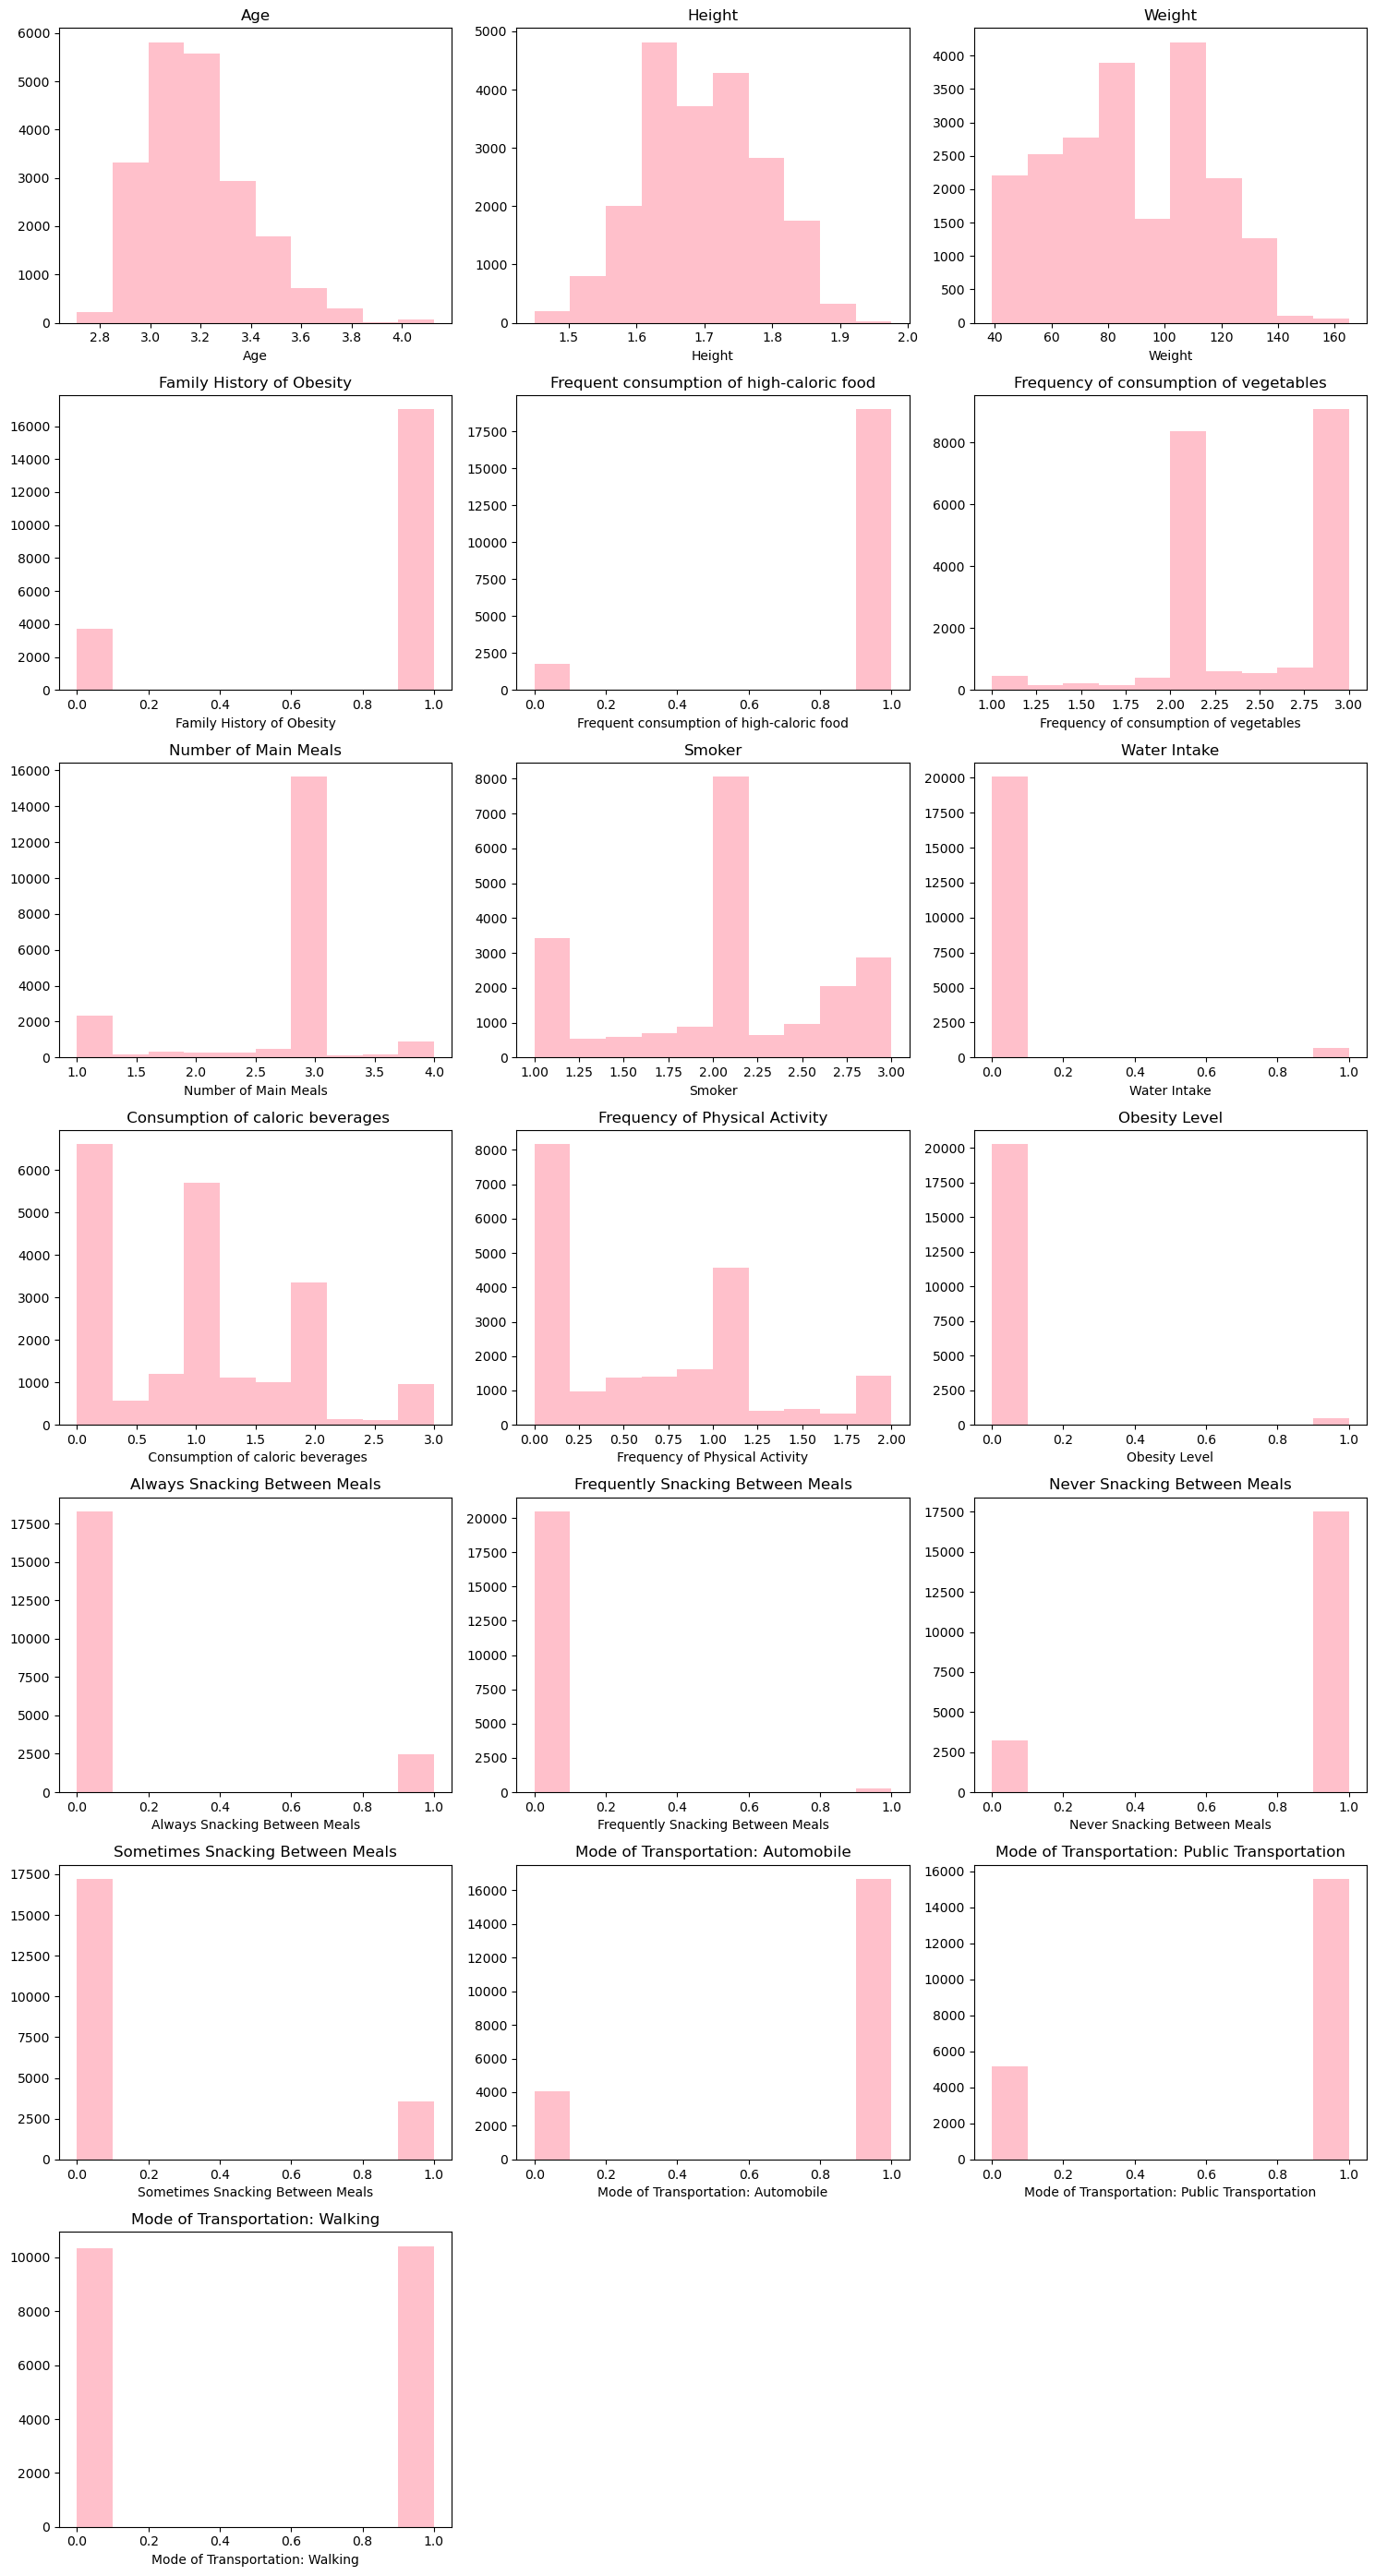

In [193]:
columns = df.columns
column_proper_names = ['Age','Height','Weight','Family History of Obesity','Frequent consumption of high-caloric food','Frequency of consumption of vegetables'
                      , 'Number of Main Meals', 'Smoker','Water Intake',' Consumption of caloric beverages', 'Frequency of Physical Activity',
                      'Time Spent on Technology','Obesity Level' , 'Always Snacking Between Meals', 'Frequently Snacking Between Meals', 'Never Snacking Between Meals',
                      'Sometimes Snacking Between Meals','Mode of Transportation: Automobile',
                      'Mode of Transportation: Public Transportation','Mode of Transportation: Walking','Alcohol Consumer', 'Mode of Transportation: Two Wheeler','Gender']

# Define subplot grid size
n_cols = 3  # number of columns of subplots
n_rows = int((len(columns) - 1) / n_cols) + 1

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 4))
axes = axes.flatten()  # flatten to easily index

plot_idx = 0

for i in range(len(columns)):
    if columns[i] == 'obesity_level':
        continue  # skip this column

    ax = axes[plot_idx]
    if df[columns[i]].dtype == 'bool':
        ax.hist(df[columns[i]].astype(int), color='pink')
    else:
        ax.hist(df[columns[i]], color='pink')
    ax.set_xlabel(column_proper_names[i])
    ax.set_title(column_proper_names[i])
    plot_idx += 1

# Hide any extra empty subplots
for j in range(plot_idx, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

### Analyzing Feature Distribution
-------------------------
#### For the mode of transportation:
- Majority of people use automobiles or public transportation. Whereas walking and two wheelers are extremely rare. This will be examined further and if its too low it'll be dropped. 

#### For the snacking between meals:
- Majority chose that they sometimes snack between meels whereas the frequency for 'Always', 'Frequently' and 'Never' are very low.

#### For the smoking:
- The smokers are too rare. This will also be examines further, and if its too low it'll be dropped. 

#### For the age:
- The age distribution is right-skewed, which can negatively affect models like logistic regression and PCA, that assume normally distributed features. To address this, I’ll apply a log1p transformation to reduce the skewness and improve model performance.

-------------------------

#### Investigating whether smoke, MTRANS_Walking and MTRANS_TwoWheeler should be dropped

In [59]:
# Removing smoke, MTRANS_Walking and MTRANS_TwoWheeler

print('Smoke Ratio: ' + str(df['SMOKE'].sum()/20758 * 100))

print('MTRANS Walking Ratio: ' + str(df['MTRANS_Walking'].sum()/20758 * 100))

print('MTRANS TwoWheeler Ratio: ' + str(df['MTRANS_TwoWheeler'].sum()/20758 * 100))

Smoke Ratio: 1.1802678485403217
MTRANS Walking Ratio: 2.2497350419115523
MTRANS TwoWheeler Ratio: 0.33721938529723483


--------------

Only ~1.2% of users smoke, ~2.5% walk as a mode of transportation, and ~0.3 use bikes or motorbikes as a mode of transportation. All of these numbers are too small to use in my model, especially once I split the data. Therefore, it'll be dropped.

--------------

In [63]:
df.drop(columns=["SMOKE"], inplace=True)
df.drop(columns=["MTRANS_Walking"], inplace=True)
df.drop(columns=["MTRANS_TwoWheeler"], inplace=True)

#### Fixing Skewed age feature

-------------------

The distribution of age is skewed to the left, this isn't good for specific techniques like logistic regression and PCA. Therefore, I'll transform the feature using `log1p` in order to reduce the skew.

-------------

In [69]:
df['Age'] = np.log1p(df['Age'])

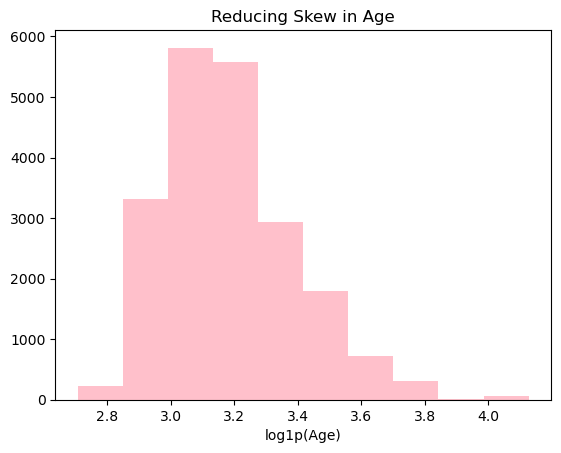

In [71]:
plt.hist(df['Age'], color='pink')
plt.xlabel('log1p(Age)')
plt.title('Reducing Skew in Age')
plt.show()

-------------------------

#### Much better!

-------------------------


### Features with Low Variance


---------------

We want to remove values which do not add anything to our model. One of the easiest ways to do this is to remove items which have a low variance. If we have variance is zero inside a feature, then this feature provides no predictive information. Similarly if our variance is very low, we might only have one or two items with any difference, and so removing the column will prevent overfitting.

---------------

In [82]:
my_mm = MinMaxScaler()
features = df.drop(columns=["obesity_level"])

----------------

Scaling the data is really important when it comes to variances because features with larger numerical ranges can dominate the overall variance, even if they’re not more informative

-----------------

In [86]:
scaled_data = my_mm.fit_transform(features)

df_scaled = pd.DataFrame(data=scaled_data, columns=features.columns)

In [97]:
# Instantiate the VarianceThresholder, we need to set a threshold variance
my_vt = VarianceThreshold(threshold=0.001)

# Fit to the data and calculate the variances per column
my_vt.fit(df_scaled)

VarianceThreshold(threshold=0.001)

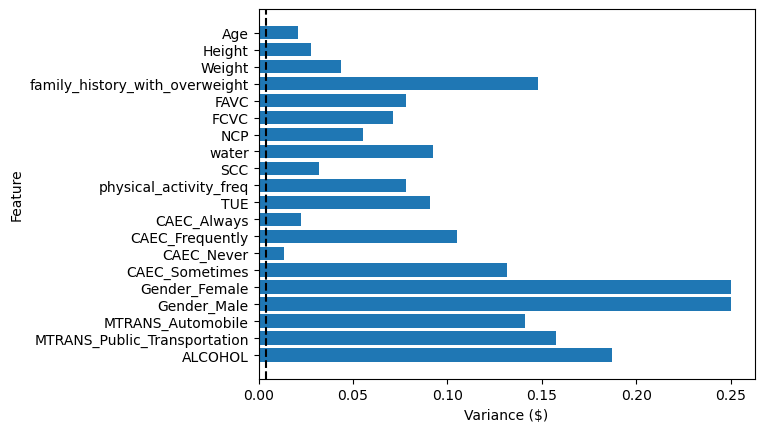

In [99]:
# Extract the variances per column
column_variances = my_vt.variances_

# Plot with the threshold
plt.figure()
plt.barh(np.flip(df_scaled.columns), np.flip(column_variances))
plt.xlabel('Variance ($)')
plt.ylabel('Feature')
plt.axvline(0.004, color='black', linestyle='--')
plt.show()

Based on the results above, I will keep all features, as their variances are greater the chosen threshold. This suggests that each feature contains meaningful information and may contribute to the model's performance.

### Obesity Level Distribution

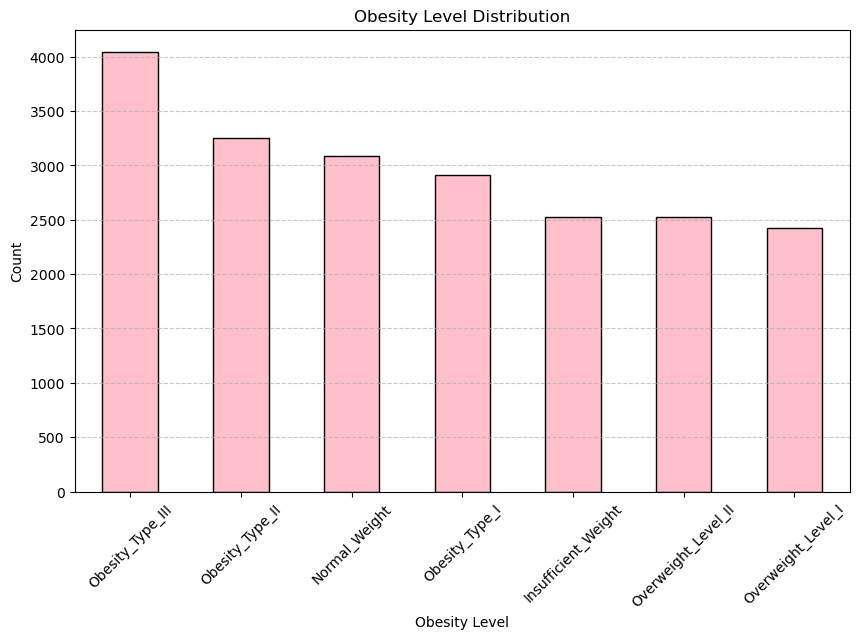

In [106]:
# Count of each obesity level
plt.figure(figsize=(10,6))
df['obesity_level'].value_counts().plot(kind='bar', color='pink', edgecolor='black')
plt.title("Obesity Level Distribution")
plt.xlabel("Obesity Level")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

## Bivariate Analysis

### Investigating the relationship of family history in obesity and obesity levels

To investigate whether obesity runs in family and how it correlates with different obesity levels, I analyzed the proportion of individuals with a family history in obesity and compared to the the obesity categories. If there's a clear pattern, this suggests a potential influence so that individuals with obese family members have a higher likelihood of becoming obese themselves.

/var/folders/rv/1qdmsxxn58x3xkwdbzlw032c0000gp/T/ipykernel_7742/4071774683.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_data = df.groupby(['obesity_level'])[feature].mean()
/var/folders/rv/1qdmsxxn58x3xkwdbzlw032c0000gp/T/ipykernel_7742/4071774683.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_data = df.groupby(['obesity_level'])[feature].mean()
/var/folders/rv/1qdmsxxn58x3xkwdbzlw032c0000gp/T/ipykernel_7742/4071774683.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current 

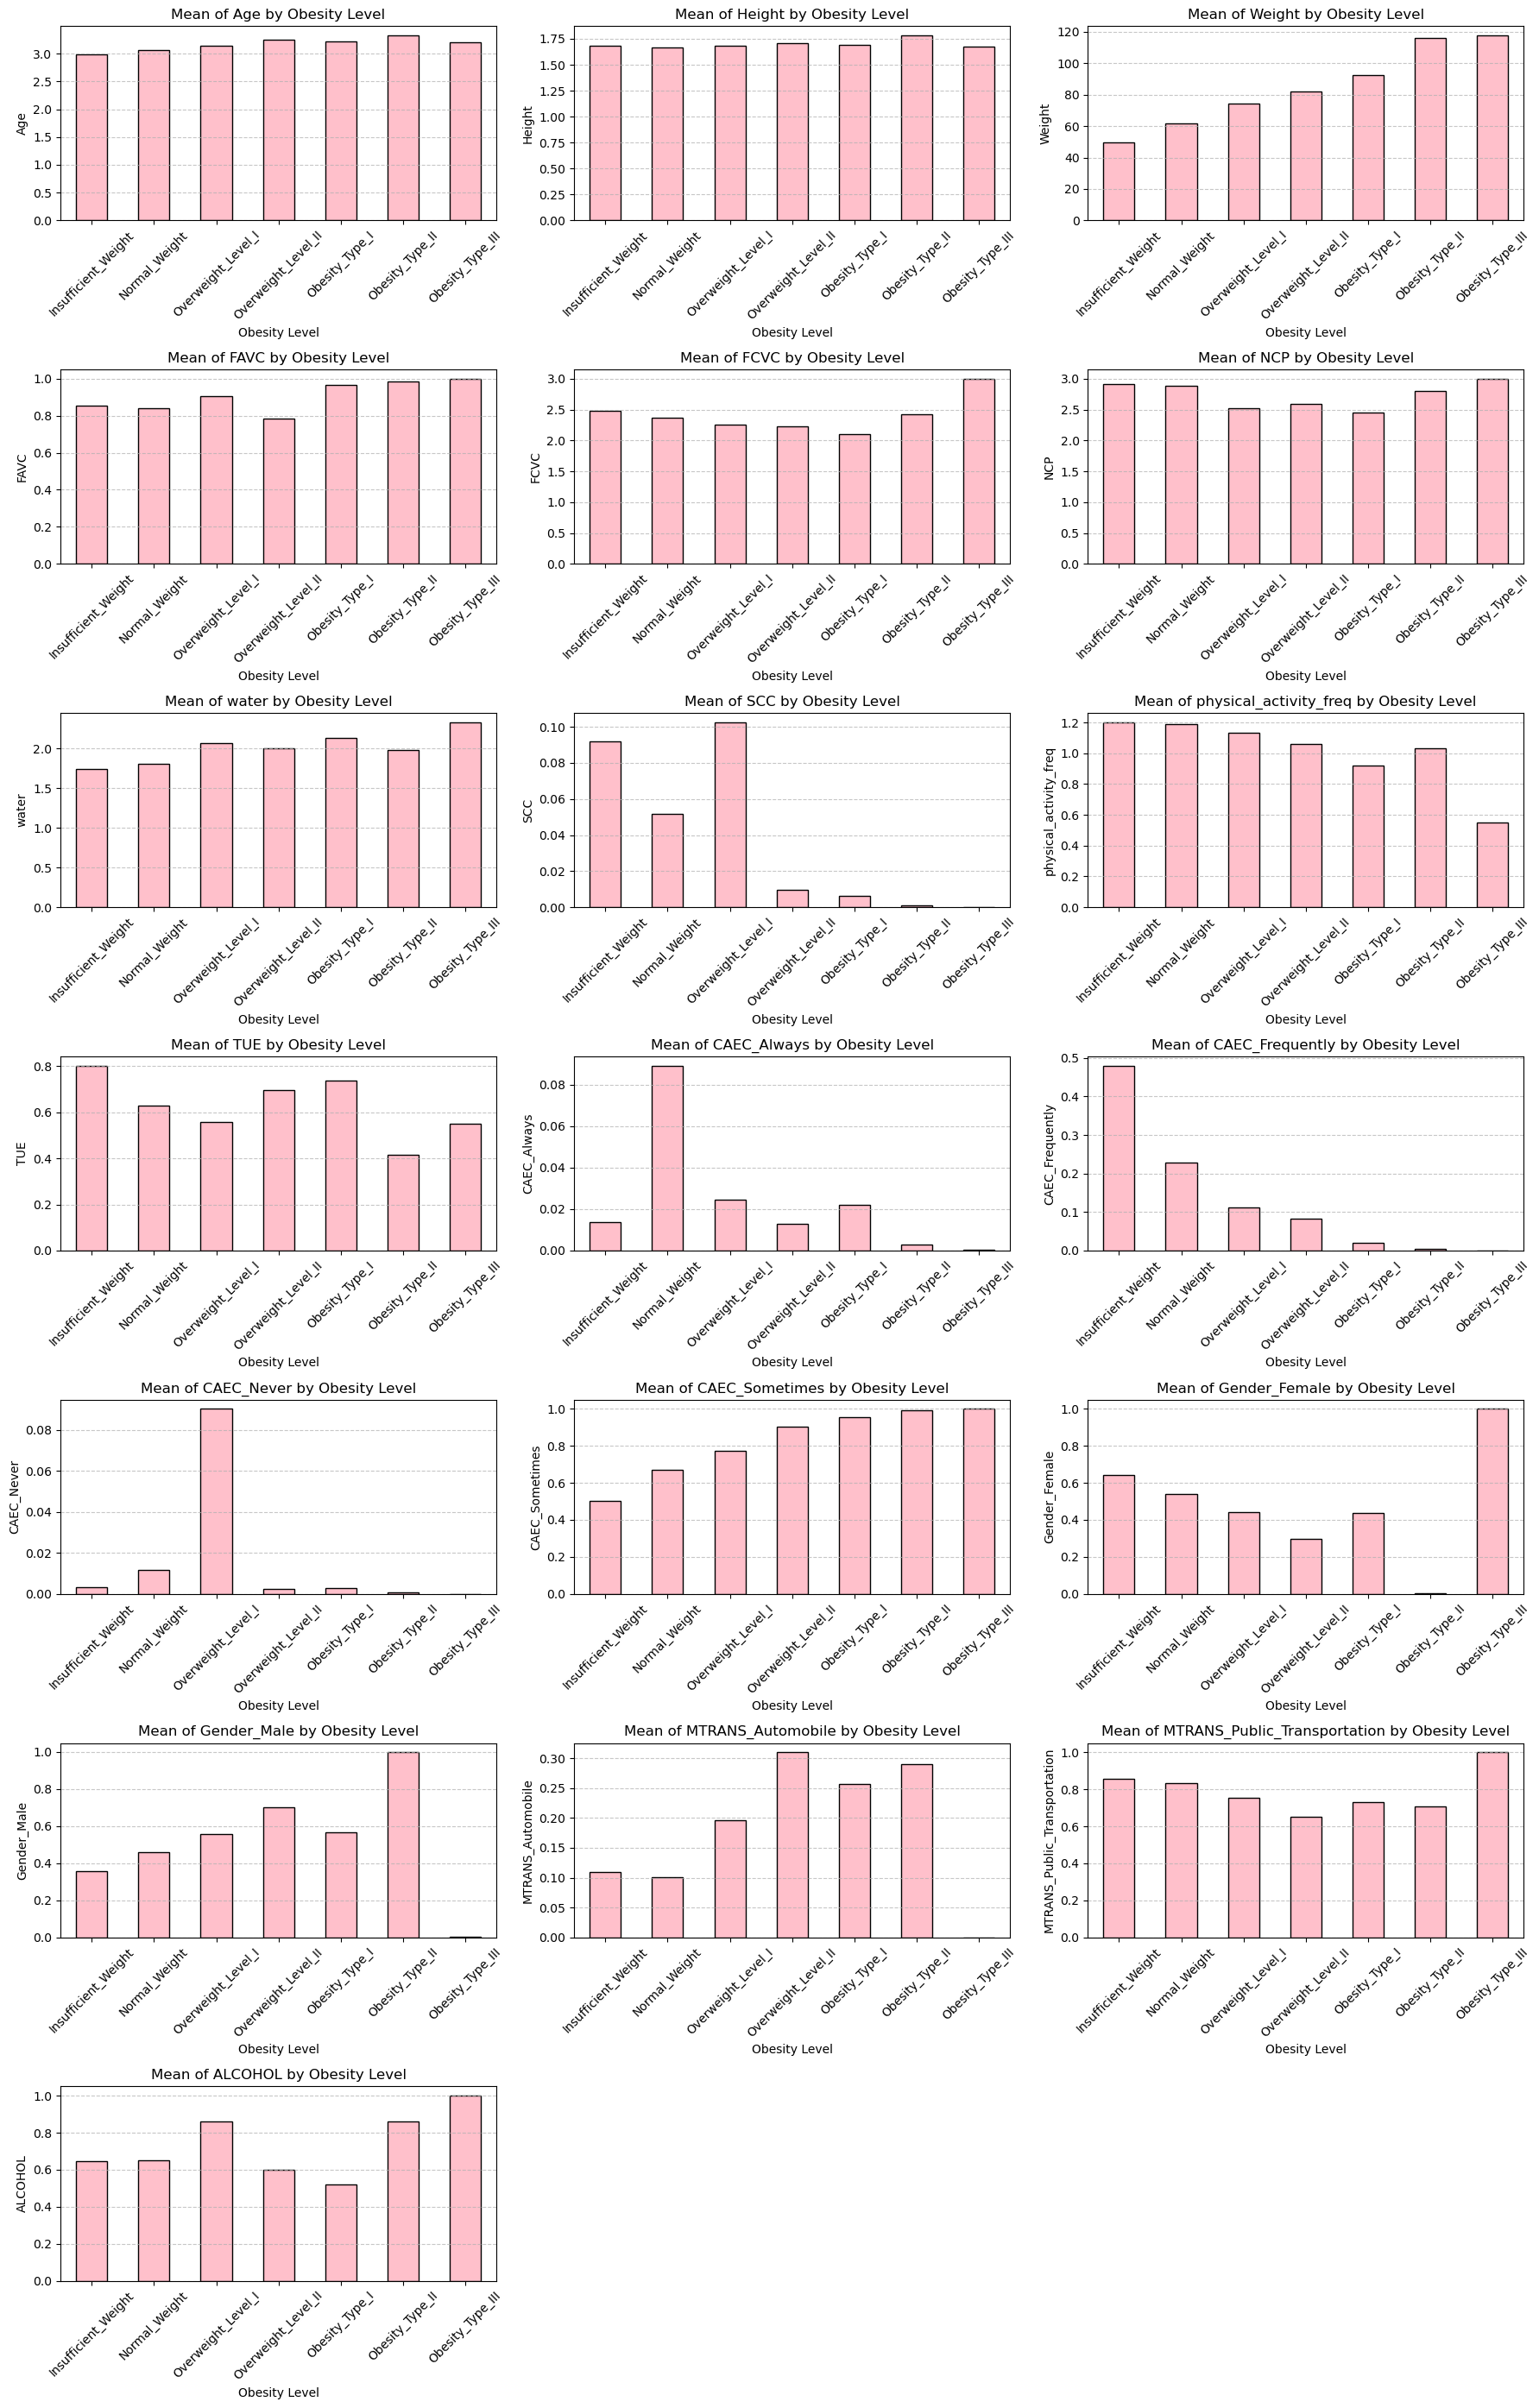

In [117]:
features = df.columns
features_to_plot = [f for f in features if f not in ['obesity_level', 'family_history_with_overweight']]

# Set grid size
n_cols = 3
n_rows = (len(features_to_plot) + n_cols - 1) // n_cols  # ceiling division

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, n_rows * 4))
axes = axes.flatten()

obesity_order = ['Insufficient_Weight', 'Normal_Weight', 'Overweight_Level_I', 
                 'Overweight_Level_II', 'Obesity_Type_I', 'Obesity_Type_II', 'Obesity_Type_III']

for idx, feature in enumerate(features_to_plot):
    ax = axes[idx]
    grouped_data = df.groupby(['obesity_level'])[feature].mean()
    grouped_data = grouped_data.reindex(obesity_order)
    
    grouped_data.plot(kind='bar', color='pink', edgecolor='black', ax=ax)
    ax.set_title(f"Mean of {feature} by Obesity Level")
    ax.set_xlabel("Obesity Level")
    ax.set_ylabel(feature)
    ax.set_xticklabels(grouped_data.index, rotation=45)
    ax.grid(axis='y', linestyle='--', alpha=0.7)

# Remove any leftover empty subplots
for j in range(idx + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


# Analysis on Histograms

----------------

- For the FAVC (Frequent consumption of high-caloric food) mean, Obesity Types I, II, and III had higher values than the other four obesity levels. This suggests that, on average, people with higher obesity levels consume high-caloric foods more frequently than those in lower obesity categories.

- Interestingly, the FCVC (Frequency of consumption of vegetables) was randomly distributed with no clear pattern. However, Obesity Type III had the highest vegetable consumption. This could suggest that there’s a limit to how much vegetables contribute to weight management, especially since some vegetables, like root vegetables and corn, are high in calories.

- Looks like Obesity Type II has the highest smoking rates, which could mean addictive tendencies show up in both food and smoking. Checking alcohol consumption could help figure out if this is more of an addiction pattern or just a coincidence, since alcohol addiction is also possible.

- For the SCC, The data shows that people with insufficient weight and Overweight Level I consume the most caloric beverages, while those in Obesity Type II and III consume the least. This might mean that people with severe obesity cut back on high-caloric drinks—maybe because they’re more health-conscious, changing their diet, or dealing with metabolic effects.

- There is a slow decline in the physical activity frequency and this makes sense.

- CAEC (Consumption of food between meals) is highest for people with normal weight, meaning they snack the most. This could suggest that frequent snacking helps them eat less during main meals, keeping their overall intake balanced. Insufficient weight individuals also snack often, but it doesn’t seem to make them eat more overall. Interestingly, Overweight Level I rarely snacks, which might mean avoiding snacks doesn’t necessarily prevent weight gain. Meanwhile, "sometimes" snacking is common across all obesity levels, but there’s a positive linear trend in the histogram—suggesting that occasional snacking might not be great for weight control. From this, it looks like always snacking might actually be better than snacking sometimes, possibly because frequent snackers eat smaller portions during main meals. A solid hypothesis would be that the more people snack, the less they eat during heavy meals, but this would need further investigation!

- For the gender histograms, the sample was pretty evenly distributed across all levels up to Obesity Level I. But for Obesity Type II, most were men, while Obesity Type III was mostly women. This could also mean that the higher smoking rates in Obesity Type II might be driven by men. The connection between smoking and gender is definitely worth looking into further to see if there’s a clear trend.

- Overweight Level II had the highest frequency of alcohol consumption compared to other groups, which actually goes against my hypothesis about Obesity Type II having addictive tendencies. If Obesity Type II were more prone to addiction, I’d expect them to also have high alcohol consumption, but instead, they mostly fall into the "sometimes consume alcohol" category. This suggests that their higher smoking rates might not be purely due to addiction but could be influenced by other factors like stress, lifestyle, or social habits.

- For transportation, higher obesity levels mostly traveled by automobile, with Overweight Level II and Obesity Type II having the highest usage. In contrast, Normal Weight and Overweight Level I groups relied more on biking and motorbikes.

Public transportation usage was pretty evenly distributed across all groups, showing no clear trend. However, walking was most common among the Normal Weight group, which makes sense since walking is often associated with maintaining a lower weight.

---------------------------

## Checking for balances classes

----------------------------

Its very important to make sure that my classes are balanced. An imbalance can cause my predictions to be swayed to the high majority and a few metrics with be inaccurate.  

----------------------------

In [125]:
df['obesity_level'].value_counts(normalize=True)

obesity_level
Obesity_Type_III       0.194913
Obesity_Type_II        0.156470
Normal_Weight          0.148473
Obesity_Type_I         0.140187
Insufficient_Weight    0.121544
Overweight_Level_II    0.121495
Overweight_Level_I     0.116919
Name: proportion, dtype: float64

--------------

The balance is pretty reasonable, my classes are not perfectly balanced, but they are not severely imbalanced either. The largest class (Obesity_Type_III, ~19.5%) and the smallest (Overweight_Level_I, ~11.7%) have about an 8% spread.

-----

# Grouped PCA

Principal Component Analysis (PCA) is an unsupervised technique that can help with two big things: reducing dimensionality and dealing with multicollinearity. Basically, the most useful features in a dataset are usually the ones with the most variance, and that’s where PCA comes in. It figures out the directions of highest variance and rebuilds the data using combinations of the original features.

PCA is a great tool — but there’s one major downside that really matters for my project: it kills interpretability. Since part of my goal is to understand which features are driving obesity in people, losing that interpretability is a problem.

A good way to balance both worlds is by using grouped PCA. Here, I divide the features into meaningful categories and apply PCA within each group. That way, I can reduce dimensionality and still get some interpretability at the group level, which helps me keep track of what’s actually going on in the data.


| Group # | Group Name               | Features                                                                                                                                  |
|---------|--------------------------|------------------------------------------------------------------------------------------------------------------------------------------|
| 1       | Demographics             | Age, Height, Weight, Gender_Female, Gender_Male                                                                                         |
| 2       | Family History           | family_history_with_overweight                                                                                                           |
| 3       | Diet / Nutrition         | FAVC, FCVC, NCP, CAEC_Always, CAEC_Frequently, CAEC_Never, CAEC_Sometimes, SCC                                                         |
| 4       | Alcohol Consumption       | Alcohol                                                                |
| 5       | Water Consumption        | water                                                                                                                                   |
| 6       | Physical Activity        | physical_activity_freq                                                                                                                  |
| 7       | Transportation & Tech   | MTRANS_Automobile, MTRANS_Public_Transportation, TUE                                     |


Here I reduced from 20 features to 7 features without losing much information. All of the very similar features are grouped into one. Now I can perform PCA on each group. Note that I scale the features first because we're going to be looking at variance. Also I set n_components = 0.9 because I want to keep 90% variance.



In [195]:
standard_scaler = StandardScaler()

# Group 1
group1 = df[['Age', 'Height', 'Weight', 'Gender']]
group1_scaled = standard_scaler.fit_transform(group1)
group1_pca = PCA(n_components=0.7)
Demographics = group1_pca.fit_transform(group1_scaled)

# Group 2
Family_History = df[['family_history_with_overweight']].values

# Group 3
group3 = df[['FAVC', 'FCVC', 'NCP', 'CAEC_Always', 'CAEC_Frequently', 'CAEC_Never', 'CAEC_Sometimes', 'SCC']]
group3_scaled = standard_scaler.fit_transform(group3)
group3_pca = PCA(n_components=0.7)
Diet_Nutrition = group3_pca.fit_transform(group3_scaled)

# Group 4
Alcohol = df['ALCOHOL'].values

# Group 5 
Water = df[['water']].values

# Group 6
Physical_Activity = df[['physical_activity_freq']].values

# Group 7
group7 = df[['MTRANS_Automobile', 'MTRANS_Public_Transportation', 'TUE']]
group7_scaled = standard_scaler.fit_transform(group7)
group7_pca = PCA(n_components=0.7)
Transportation_Tech = group7_pca.fit_transform(group7_scaled)

------------

Now some of the groups that turned into PCA's have multiple principle components. 

-------------

In [198]:
print('Demographics Size: '+str(Demographics.shape))
print('Diet_Nutrition Size: '+str(Diet_Nutrition.shape))
print('Transportation_Tech Size: '+str(Transportation_Tech.shape))

Demographics Size: (20758, 2)
Diet_Nutrition Size: (20758, 5)
Transportation_Tech Size: (20758, 2)


In [200]:
Alcohol.shape

(20758,)

----------

Forming df with pca components

---------

In [203]:
data_pca = {
    "Demographics_PC_1": Demographics[:,0],
    "Demographics_PC_2": Demographics[:,1],
    "Family_History": Family_History[:,0],
    "Diet_Nutrition_PC_1": Diet_Nutrition[:,0],
    "Diet_Nutrition_PC_2": Diet_Nutrition[:,1],
    "Diet_Nutrition_PC_3": Diet_Nutrition[:,2],
    "Diet_Nutrition_PC_4": Diet_Nutrition[:,3],
    "Diet_Nutrition_PC_5": Diet_Nutrition[:,4],
    "Alcohol": Alcohol,
    "Water": Water[:,0],
    "Physical_Activity": Physical_Activity[:,0],
    "Transportation_Tech_PC_1": Transportation_Tech[:,0],
    "Transportation_Tech_PC_2": Transportation_Tech[:,1],
}

df_pca = pd.DataFrame(data_pca)

In [205]:
df_pca

,Demographics_PC_1,Demographics_PC_2,Family_History,Diet_Nutrition_PC_1,Diet_Nutrition_PC_2,Diet_Nutrition_PC_3,Diet_Nutrition_PC_4,Diet_Nutrition_PC_5,Alcohol,Water,Physical_Activity,Transportation_Tech_PC_1,Transportation_Tech_PC_2
0,0.489155,-0.340382,1,0.643884,-0.239030,0.239140,-0.067379,-0.554224,1,2.763573,0.000000,-0.790051,0.424592
1,-2.392811,-0.592022,1,-3.147356,0.169908,0.190748,-1.480216,-1.205143,0,2.000000,1.000000,2.762927,1.311933
2,-1.399099,-1.187822,1,0.714120,-1.685918,-0.260831,-0.017824,-0.821012,0,1.910378,0.866045,-1.059272,1.550372
3,0.163687,0.625871,1,0.676189,0.756827,0.091304,-0.243484,0.708778,1,1.674061,1.467863,-0.714251,0.107624
4,2.545157,0.104623,1,0.714140,-0.427804,-0.198765,-0.168482,0.228641,1,1.979848,1.967973,-0.772768,0.352321
...,...,...,...,...,...,...,...,...,...,...,...,...,...
20753,1.608299,0.174075,1,0.673528,0.677880,0.103635,-0.229347,0.607311,1,2.151809,1.330519,-0.488898,-0.834713
20754,-0.294831,-1.935848,0,-3.161469,1.997648,0.367187,-1.674185,0.130467,1,1.000000,2.000000,-0.799137,0.462586
20755,1.620625,-0.922654,1,0.656592,0.175466,0.182112,-0.139377,-0.038420,0,2.000000,1.158040,-0.875773,0.783049
20756,0.843221,0.812105,1,0.713861,-0.436076,-0.197473,-0.167001,0.218009,0,2.144838,0.000000,2.773033,1.269676


# Baseline Model

# Logistic Regression 
-------

In order to perform logistic regression on the data these following assumptions need to be true

1. Linearity of the logit: logistic regression assumes a linear relationship between the independent variables and the log-odds of the dependent variable.
2. No multicollinearity: logistic regression assumes that variables are independent of one another.
3. Independent observations: Observations should be independent of one another.

-------



## Multicollinearity

-----------

Next, I'll check for multicollinearity to see if any features are highly correlated. If they are, they’ll be removed during logistic analysis since redundant features don’t add much new information and can distort coefficient interpretations.


---------

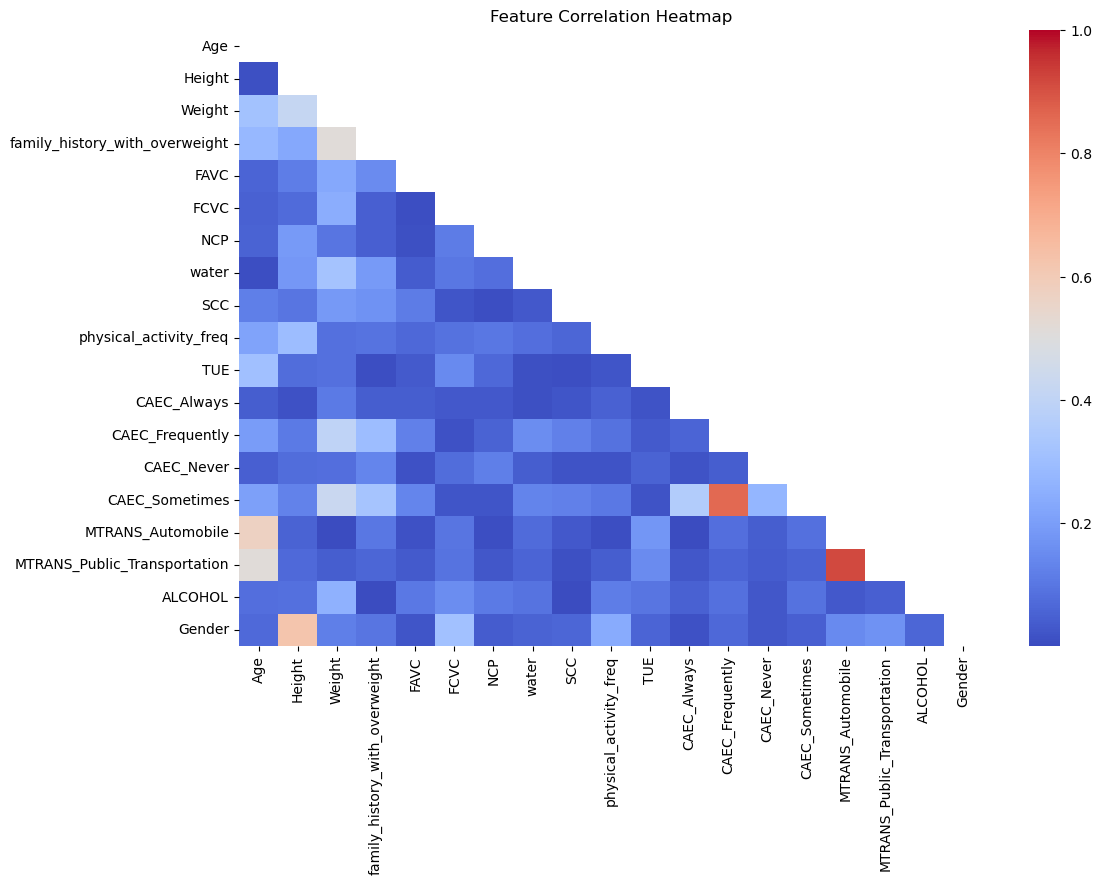

In [229]:
X = df.drop(columns=['obesity_level'])  # Drop target column
corr_matrix = X.corr().abs()
plt.figure(figsize=(12,8))
matrix = np.triu(corr_matrix)
sns.heatmap(corr_matrix, cmap="coolwarm", annot=False, mask=matrix,vmax=1)
plt.title("Feature Correlation Heatmap")
plt.show()

---------------

When creating dummy variables the first column should be dropped and this is because by keeping all of them perfect multicollinearity will be introduced and this is because one category can be predicted once others are known. Therefore the following columns will get dropped: 

- 'CAEC_Always'

Now with those changes, this will be the new multicollinearity plot

---------------

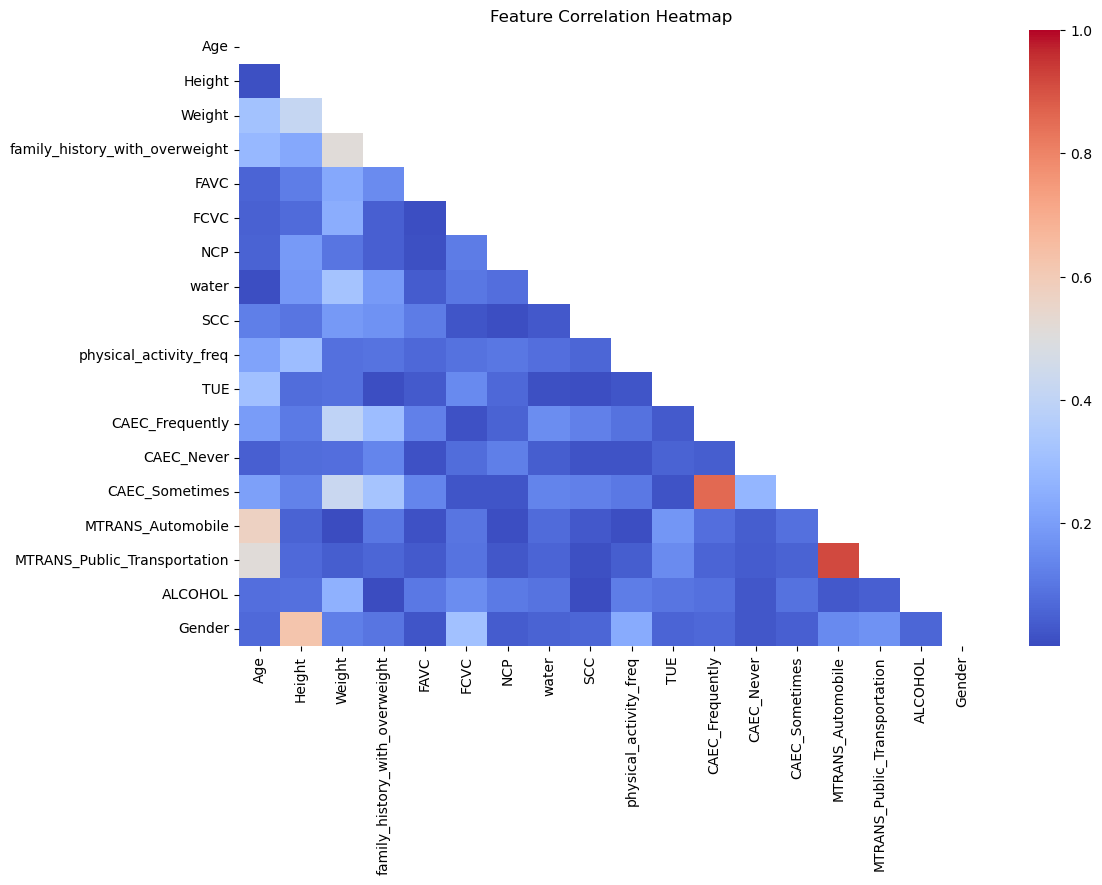

In [227]:
X = df.drop(columns=['obesity_level','CAEC_Always']) 
corr_matrix = X.corr().abs()
plt.figure(figsize=(12,8))
matrix = np.triu(corr_matrix)
sns.heatmap(corr_matrix, cmap="coolwarm", annot=False, mask=matrix,vmax=1)
plt.title("Feature Correlation Heatmap")
plt.show()

In [213]:
X = df.drop(columns=['obesity_level','CAEC_Always']) 
X_train, X_test, y_train, y_test = train_test_split(X, df["obesity_level"], test_size=0.2, random_state=42)

# I'm scaling the features because the weight is in the hundreds and the other features are in ones. This is to prevent convergance issues.
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train_scaled, y_train)
y_pred = log_reg.predict(X_test_scaled)


accuracy = accuracy_score(y_test, y_pred)
print("Model Accuracy:", accuracy)

Model Accuracy: 0.865606936416185


-----------------------------------------------------------------------

Next, a few features are highly correlated. To see which one I should drop, I'll run the logistic regression on either or to see which one improves accuracy. 

Accuracy before testing which one to drop: 0.86560

-----------------------------------------------------------------------

'CAEC_Frequently' vs. 'CAEC_Sometimes'

Accuracy when dropping 'CAEC_Frequently' : 0.86560

Accuracy when dropping 'CAEC_Sometimes' : .86729

Conclusion: Drop 'CAEC_Sometimes'

----------------------------------------------------------------------

'MTRANS_automobile' vs 'MTRANS_Public_Transportation'

Accuracy when dropping 'MTRANS_automobile': 0.86440

Accuracy when dropping 'MTRANS_Public_Transportation': 0.86536

Conclusion: Drop 'MTRANS_Public_Transportation'

-----------------------------------------------------------------------

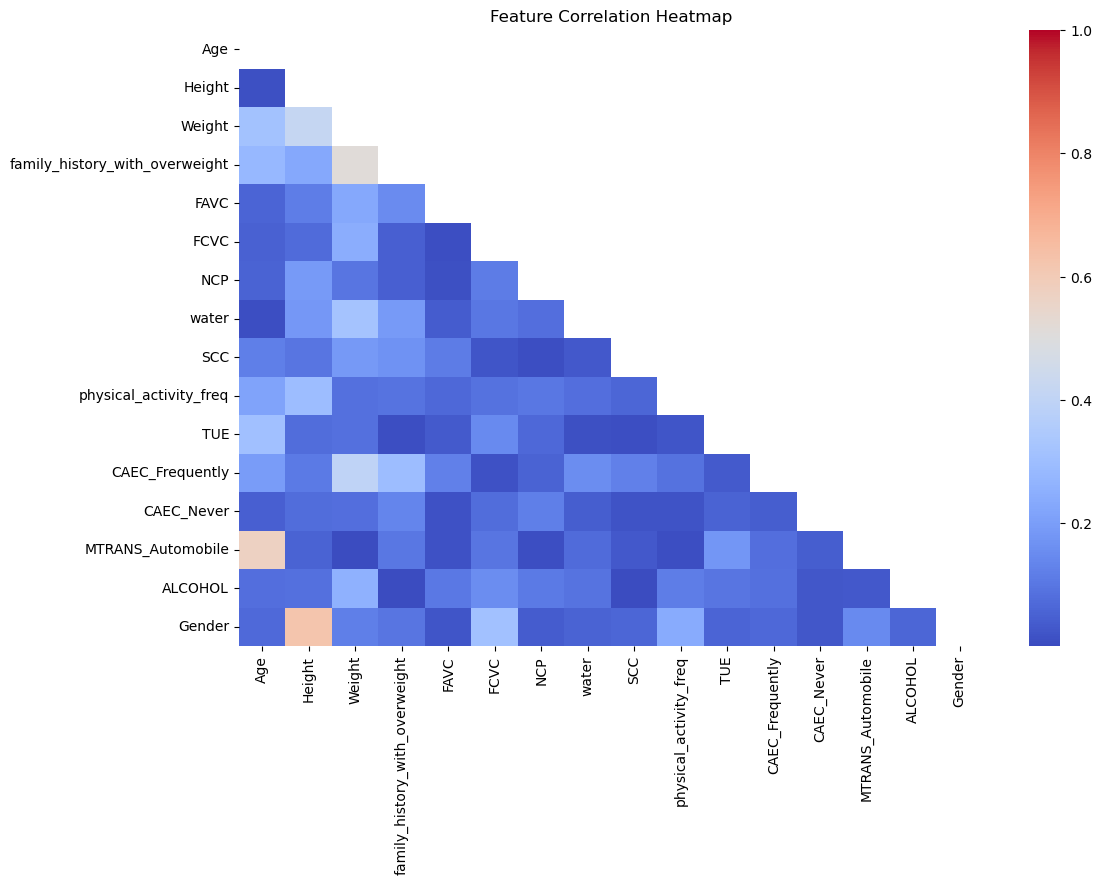

In [225]:
X = df.drop(columns=['obesity_level','CAEC_Always','CAEC_Sometimes','MTRANS_Public_Transportation']) 
corr_matrix = X.corr().abs()
plt.figure(figsize=(12,8))
matrix = np.triu(corr_matrix)
sns.heatmap(corr_matrix, cmap="coolwarm", annot=False, mask=matrix,vmax=1)
plt.title("Feature Correlation Heatmap")
plt.show()

## Regular Dataset, Grouped PCA, PCA

#### Using regular dataset

In [305]:
X = df.drop(columns=['obesity_level','CAEC_Always','CAEC_Sometimes','MTRANS_Public_Transportation']) 
y = df["obesity_level"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# I'm scaling the features because the weight is in the hundreds and the other features are in ones. This is to prevent convergance issues.
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train_scaled, y_train)
y_pred = log_reg.predict(X_test_scaled)


accuracy = accuracy_score(y_test, y_pred)
print("Model Accuracy:", accuracy)

Model Accuracy: 0.8668111753371869


#### Using Grouped PCA

In [264]:
X = df_pca
y = df["obesity_level"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# I'm scaling the features because the weight is in the hundreds and the other features are in ones. This is to prevent convergance issues.
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train_scaled, y_train)
y_pred = log_reg.predict(X_test_scaled)


accuracy = accuracy_score(y_test, y_pred)
print("Model Accuracy:", accuracy)

Model Accuracy: 0.6830443159922929


Using the grouped PCA clearly didn't help at all, my models accuracy dropped by ~20%! Next, just for validation I'll look into what would happened if I used PCA instead of grouped PCA.

#### Using Regular PCA

In [266]:
X = df.drop(columns=['obesity_level','CAEC_Always','CAEC_Sometimes','MTRANS_Public_Transportation']) 
y = df["obesity_level"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# I'm scaling the features because the weight is in the hundreds and the other features are in ones. This is to prevent convergance issues.
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train_pca, y_train)
y_pred = log_reg.predict(X_test_pca)


accuracy = accuracy_score(y_test, y_pred)
print("Model Accuracy:", accuracy)

Model Accuracy: 0.7415703275529865


---------------

Interestingly, applying PCA actually made my model worse. I think it's because PCA keeps the components with the most variance, not necessarily the ones that are most useful for predicting obesity. So it probably threw away some important signals. Plus, since PCA turns everything into abstract components, it makes it harder for logistic regression to learn from the original features properly.

---------------

## Logistic Regression: Hyperparameter Tuning with Pipelining

In [313]:
X = df.drop(columns=['obesity_level','CAEC_Always','CAEC_Sometimes','MTRANS_Public_Transportation']) 
y = df["obesity_level"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

estimators = [('normalise', StandardScaler()),
              ('model', LogisticRegression())]

pipe = Pipeline(estimators)

param_grid = [
    {'model': [LogisticRegression(max_iter=5000)],
     'normalise': [StandardScaler()],
     'model__penalty': ['l1', 'l2'],
     'model__solver': ['saga'],
     'model__C': [0.1, 1, 10]},
    
    {'model': [LogisticRegression(max_iter=5000)],
     'normalise': [StandardScaler()],
     'model__penalty': ['l2'],
     'model__solver': ['lbfgs'],
     'model__C': [0.1, 1, 10]}
]

grid = GridSearchCV(pipe, param_grid, cv=5)
fittedgrid = grid.fit(X_train, y_train)

In [314]:
fittedgrid.best_estimator_

Pipeline(steps=[('normalise', StandardScaler()),
                ('model',
                 LogisticRegression(C=10, max_iter=5000, penalty='l1',
                                    solver='saga'))])

In [359]:
fittedgrid.fit(X_train, y_train)


y_pred = fittedgrid.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.871868978805395


-------------------------

The pipeline made the whole process cleaner, and GridSearchCV helped me find the best combo of solver, penalty, and regularization. Overall, it made the model more balanced and better at generalizing than just using the default settings. The accuracy increased from 86.68% to 87.18%. 

-------------------------

## Linearity of the logit

/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


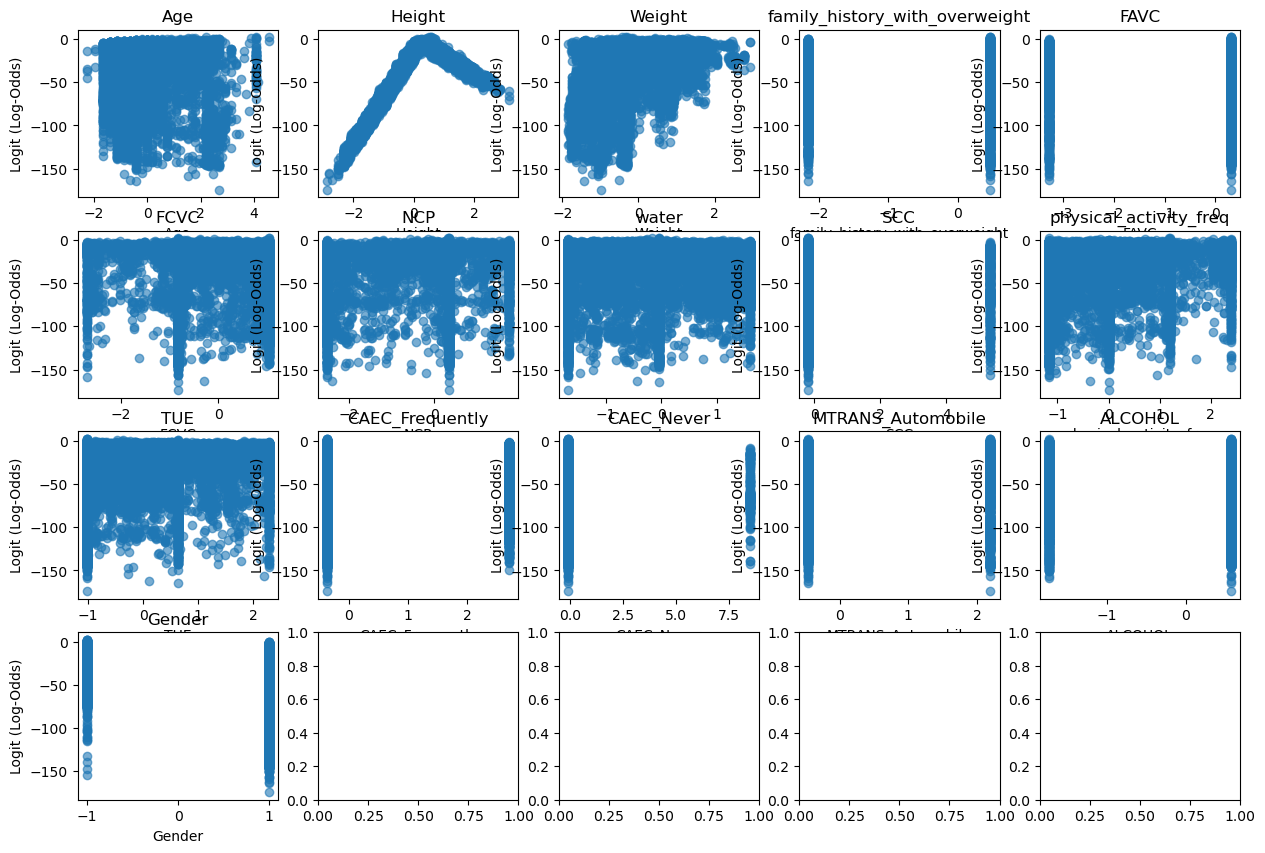

In [243]:
y_prob = fittedgrid.predict_proba(X_train_scaled)[:, 1]

logit_values = np.log(y_prob / (1 - y_prob))

X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X.columns)


fig, axes = plt.subplots(4, 5, figsize=(15, 10))  
axes = axes.ravel()
for i, col in enumerate(X.columns):
    axes[i].scatter(X_train_scaled_df[col], logit_values, alpha=0.6)
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Logit (Log-Odds)')
    axes[i].set_title(col)



--------------

By looking at the plots above we can tell that logistic regression wont work because the relationships aren't linear. But a very important reason as to why I won't consider logistic regression is because I want to know which features contribute to obesity. Logistic Regression doesn't show that. 

---------------

## Model Evaluation

### Classification Report


In [363]:
print(classification_report(y_test, y_pred))


                     precision    recall  f1-score   support

Insufficient_Weight       0.89      0.94      0.91       524
      Normal_Weight       0.86      0.82      0.84       626
     Obesity_Type_I       0.83      0.84      0.84       543
    Obesity_Type_II       0.96      0.97      0.97       657
   Obesity_Type_III       1.00      1.00      1.00       804
 Overweight_Level_I       0.73      0.74      0.73       484
Overweight_Level_II       0.73      0.69      0.71       514

           accuracy                           0.87      4152
          macro avg       0.86      0.86      0.86      4152
       weighted avg       0.87      0.87      0.87      4152



----------------

- The model achieved 87% accuracy, with good precision and recall across most obesity classes.
  
- It performed best on Obesity_Type_III and II, while Overweight levels were harder to separate.

- Overall, the scores are well-balanced, with a macro F1 of 86%.


-----------

In [386]:
print(confusion_matrix(y_test, y_pred))

[[492  30   0   0   0   1   1]
 [ 57 514   0   0   0  52   3]
 [  2   2 458  22   3   9  47]
 [  0   0  13 640   0   0   4]
 [  0   0   0   1 802   0   1]
 [  1  40  10   0   0 357  76]
 [  0  10  72   4   0  71 357]]


# Decision Trees

--------------

Decision trees are a type of model that splits the data into branches based on conditions, kind of like a flowchart. They make decisions by asking a series of yes/no questions about the features, which eventually leads to a final prediction. They're super easy to understand and interpret, which makes them great for explaining how the model is making its decisions


Pros of desicison trees:
- very easy to understand and interpret
- Can tell me the important features
- Can work with non-linearity

cons: 
- Can lead to overfitting especially if the tree runs deep or if there are many splitting branches. A way to combat this is to set a max depth. But this would intoroduce bias.

--------------

### Parameters
--------------
Here are the following parameters we're going to tune and adjust:

1. `max_depth` – This controls how deep the tree can go. It helps prevent the model from becoming too complicated and overfitting by stopping it from making endless splits.

2. `min_samples_leaf` – This sets the minimum number of data points that have to be in a leaf. It makes sure the model doesn’t get too specific and try to fit tiny patterns that don’t generalize.

3. `min_samples_split` – This tells the tree how many samples are needed before it’s allowed to split. Increasing it helps simplify the tree and avoid overfitting.

4. `criterion` – This is how the model decides where to split. I’m testing both 'gini' and 'entropy' to see which works best.


--------------

In [327]:
# Create a copy just to prevent any duplicates or mistakes from the previous model

decision_tree_df = df.copy()

--------------

Since I'm using a decision tree classifier, the target variable (obesity_level) needs to be numeric. So I mapped each obesity class to a number using obesity_mapping.

--------------

In [332]:
obesity_mapping = {
    'Insufficient_Weight': 0,
    'Normal_Weight': 1,
    'Overweight_Level_I': 2,
    'Overweight_Level_II': 3,
    'Obesity_Type_I': 4,
    'Obesity_Type_II': 5,
    'Obesity_Type_III': 6
}

# Apply mapping to the 'obesity_level' column
decision_tree_df['obesity_level'] = decision_tree_df['obesity_level'].map(obesity_mapping)

-----------------

It's very important for the target variable to be balanced in decision trees, the model learns by splitting the data and if one class dominates the dataset, the tree might get lazy and just keep predicting the majority class to boost accuracy. Even if it's not actually learning meaningful patterns for the minority classes.

The class distribution in our dataset is fairly balanced, with the smallest class representing ~11.7% of the data and the largest class ~19.5%. Since no class is severely underrepresented, stratification is not strictly necessary for Decision Trees.

-----------------

In [337]:
X_dec_trees = decision_tree_df.drop(columns=['obesity_level'])  
y_dec_trees = decision_tree_df['obesity_level']  

In [341]:
X_dec_trees_train, X_dec_trees_test, y_dec_trees_train, y_dec_trees_test = train_test_split(X_dec_trees, y_dec_trees, test_size=0.2, random_state=42)

## Decision Trees: Hyperparameter Tuning with Pipelining

In [347]:
# Scaling for decision trees isn't required since decision trees are not distance based. 

pipe = Pipeline([
    ('model', DecisionTreeClassifier())
])

param_grid = {
    'model__criterion': ['gini', 'entropy'],
    'model__max_depth': [1, 3, 5, 7, 9, 11],
    'model__min_samples_leaf': [1, 2, 5, 10, 20],
    'model__min_samples_split': [12, 14, 16, 18, 20]
}

grid_DT = GridSearchCV(pipe, param_grid, cv=5)
fittedgrid_DT = grid_DT.fit(X_dec_trees_train, y_dec_trees_train)

/opt/anaconda3/lib/python3.12/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


In [375]:
fittedgrid_DT.best_estimator_

Pipeline(steps=[('model',
                 DecisionTreeClassifier(criterion='entropy', max_depth=9,
                                        min_samples_leaf=20,
                                        min_samples_split=12))])

In [348]:
fittedgrid_DT.fit(X_dec_trees_train, y_dec_trees_train)


y_pred_DT = fittedgrid_DT.predict(X_dec_trees_test)
accuracy = accuracy_score(y_dec_trees_test, y_pred_DT)
print("Accuracy:", accuracy)


Accuracy: 0.8759633911368016


/opt/anaconda3/lib/python3.12/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


# Ensemble Learning: Random Forest

A random forest is an ensemble of decision trees. Each tree is trained on a different subset of the data.
